In [1]:
import fiona
from shapely import geometry, wkt
from shapely.geometry import shape
from shapely.ops import transform

import json
import geojson

from functools import partial
import pyproj
import utm
import pdal

In [2]:
## awkward hack to import local modules in Jupyter
import sys
sys.executable
sys.path.append('/mnt/bigdata/frontierSI/qa4mbes-data-pipeline/qa4mbes')

In [3]:
with fiona.open("../tests/testcoverage.shp") as shapefile:
    geometry = shapefile[0]["geometry"]
    print(shapefile[0])

{'type': 'Feature', 'id': '0', 'properties': OrderedDict([('id', 0)]), 'geometry': {'type': 'Polygon', 'coordinates': [[(148.52130039229576, -41.824085859822155), (148.52847609278288, -41.82379242969071), (148.52934304544397, -41.826379949940716), (148.5223273977558, -41.82779374966494), (148.5196865265728, -41.82603316887628), (148.52130039229576, -41.824085859822155)]]}}


In [4]:
geometry

{'type': 'Polygon',
 'coordinates': [[(148.52130039229576, -41.824085859822155),
   (148.52847609278288, -41.82379242969071),
   (148.52934304544397, -41.826379949940716),
   (148.5223273977558, -41.82779374966494),
   (148.5196865265728, -41.82603316887628),
   (148.52130039229576, -41.824085859822155)]]}

In [5]:
strgeom = str(json.dumps(geometry))

In [6]:
geometry = geojson.loads(strgeom)

In [7]:
refpoly = shape(geometry)

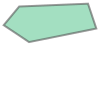

In [8]:
refpoly

In [9]:
import getpointcoverage

In [10]:
testcoverage = getpointcoverage.getpointcoverage("../tests/4819-100000lines.laz")

reprojecting
+proj=utm +zone=55 +south +datum=WGS84 +units=m +no_defs


In [11]:
testcoverage

'{"type": "MultiPolygon", "coordinates": [[[[148.52976760305208, -41.829976879424215], [148.52969486737055, -41.82988641512254], [148.52960078869697, -41.82988766823904], [148.52955302390032, -41.82985782670189], [148.52962285738508, -41.829826418835886], [148.52970626443926, -41.82987102444539], [148.52980034308382, -41.82986977124288], [148.5298345341883, -41.829823599178084], [148.52977537229856, -41.82980914842364], [148.5297055389098, -41.82984055638092], [148.52972760748244, -41.82977930695907], [148.52962068092214, -41.8297350146377], [148.5294795632371, -41.82973689418696], [148.52952587702615, -41.82970579962207], [148.5297261564091, -41.8297183708296], [148.5297603474902, -41.82967219878618], [148.52956079370244, -41.829690095703356], [148.5294417449123, -41.82963072580528], [148.52937118618013, -41.82963166548975], [148.52941749994847, -41.82960057096841], [148.52948878406517, -41.82963009932489], [148.52979453852294, -41.82962602673302], [148.5298287295071, -41.829579854670

In [12]:
thing = "+proj=utm +zone=55 +south +datum=WGS84 +units=m +no_defs"
thing="+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs "

In [13]:
if thing.find('longlat') > 0:
    xyz

NameError: name 'xyz' is not defined

In [ ]:
def tolatlon(geometry, projcrs):
    # lazily assume input geometry is latlon/EPSG:4326
    print('reprojecting')
    print(projcrs)
    # from: https://gis.stackexchange.com/questions/127427/transforming-shapely-polygon-and-multipolygon-objects
    project = partial(
        pyproj.transform,
        pyproj.Proj(projcrs),  # source coordinate system
        pyproj.Proj(init='epsg:4326'))  # destination coordinate system

    return transform(project, geometry)

In [ ]:
project = partial(
        pyproj.transform,
        pyproj.Proj(thing),  # source coordinate system
        pyproj.Proj(init='epsg:3577'))  # destination coordinate system

this = transform(project, refpoly)

In [ ]:
this = tolatlon(refpoly, thing)

In [ ]:
this

In [ ]:
refpoly.intersection(testcoverage)

In [ ]:
intersect = refpoly.intersection(testcoverage)

In [ ]:
refpoly.intersection(testgeom).area

In [ ]:
testgeom.centroid.to_wkt()

In [ ]:
refpoly.centroid.xy

In [ ]:
testpoly_coords = refpoly.centroid.xy

In [ ]:
testpoly_coords[1][0]

In [ ]:
utm.from_latlon(testpoly_coords[1][0], testpoly_coords[0][0])

In [ ]:
project = partial(
    pyproj.transform,
    pyproj.Proj(init='epsg:4326'), # source coordinate system
    pyproj.Proj(init='epsg:32755')) # destination coordinate system

In [ ]:
g2 = transform(project, refpoly)

In [ ]:
g2.area

In [ ]:
g3 = transform(project,intersect)

In [ ]:
g3.area

In [ ]:
g3.area / g2.area

In [ ]:
def transformtoutm(geometry):
    #lazily assume input geometry is latlon/EPSG:4326
    refpoint = geometry.centroid.xy
    utmzone = utm.from_latlon(refpoint[1][0], refpoint[0][0])

    if refpoint[1][0] > 0:
        epsgcode = 'epsg:326'+str(utmzone[2])
    else:
        epsgcode = 'epsg:327'+str(utmzone[2])
    # from: https://gis.stackexchange.com/questions/127427/transforming-shapely-polygon-and-multipolygon-objects
    project = partial(
        pyproj.transform,
        pyproj.Proj(init='epsg:4326'), # source coordinate system
        pyproj.Proj(init=epsgcode)) # destination coordinate system

    return transform(project, geometry)

In [ ]:
def intersectinmetres(refgeom, testgeom):
    """
    give two geometries which intersect, transform to utm,
    return area in square metres, and percent coverage
    """
    utmref = transformtoutm(refgeom)
    utmtest = transformtoutm(testgeom)

    intersection = utmref.intersection(utmtest)

    intersectionarea = intersection.area
    intersectionpercent = intersection.area / utmref.area

    return [intersectionarea, intersectionpercent]

In [ ]:
intersectinmetres(refpoly, testgeom)

In [ ]:
geojson.dumps(intersect)

In [ ]:
def runpdal(pipeline):
    pipeline = pdal.Pipeline(json.dumps(pipeline))
    pipeline.validate()
    pipeline.loglevel = 2  # stay quiet
    count = pipeline.execute()
    metadata = json.loads(pipeline.metadata)
    log = pipeline.log

    return metadata

In [ ]:
inputfile = "../tests/4819-100000lines.laz"
pipeline = {
        "pipeline": [
            {
                "type": "readers.las",
                "filename": inputfile
            }
        ]
    }

metadata = runpdal(pipeline)

print(json.dumps(metadata["metadata"]["readers.las"][0]["srs"]["proj4"]))

In [ ]:
print(json.dumps(metadata["metadata"]["readers.las"][0]["spatialreference"]))